# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [1]:
import pandas as pd
import zipfile
import glob
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
import seaborn
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import os
import urllib.request as urllib
import geopandas as gpd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Business Data

In [2]:
#these commands can be run on the shell and get the data with the command wget
#the cell needs to be run only once
!for ((y=93; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done



--2017-12-20 01:41:07--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2017-12-20 01:41:08 ERROR 404: Not Found.

--2017-12-20 01:41:08--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: “zbp94totals.zip”

100%[======================================>] 611,524     --.-K/s   in 0.08s   

2017-12-20 01:41:08 (6.97 MB/s) - “zbp94totals.zip” saved [611524/611524]

--2017-12-20 01:41:08--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp95totals.zip
Resolving www2.census.gov... 104

HTTP request sent, awaiting response... 200 OK
Length: 660109 (645K) [application/zip]
Saving to: “zbp09totals.zip”

100%[======================================>] 660,109     --.-K/s   in 0.04s   

2017-12-20 01:41:09 (17.9 MB/s) - “zbp09totals.zip” saved [660109/660109]

--2017-12-20 01:41:10--  https://www2.census.gov/econ2010/CBP_CSV/zbp10totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797534 (779K) [application/zip]
Saving to: “zbp10totals.zip”

100%[======================================>] 797,534     --.-K/s   in 0.03s   

2017-12-20 01:41:10 (29.7 MB/s) - “zbp10totals.zip” saved [797534/797534]

--2017-12-20 01:41:10--  https://www2.census.gov/econ2011/CBP_CSV/zbp11totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.2

In [3]:
#get all data file names
allfilezip = glob.glob("*.zip")
allfilezip

['zbp94totals.zip',
 'zbp95totals.zip',
 'zbp96totals.zip',
 'zbp97totals.zip',
 'zbp98totals.zip',
 'zbp99totals.zip',
 'zbp00totals.zip',
 'zbp01totals.zip',
 'zbp02totals.zip',
 'zbp03totals.zip',
 'zbp04totals.zip',
 'zbp05totals.zip',
 'zbp06totals.zip',
 'zbp07totals.zip',
 'zbp08totals.zip',
 'zbp09totals.zip',
 'zbp10totals.zip',
 'zbp11totals.zip',
 'zbp12totals.zip',
 'zbp13totals.zip',
 'zbp14totals.zip']

In [4]:
#move all download zipdata to PUIdata folder
for i in allfilezip:
    os.system('mv ' + i + ' $PUIDATA')

In [5]:
#get all unzipped data file names
os.chdir(os.getenv('PUIDATA'))
allfile = glob.glob("zbp*.zip")

In [6]:
allfile

['zbp94totals.zip',
 'zbp95totals.zip',
 'zbp96totals.zip',
 'zbp97totals.zip',
 'zbp98totals.zip',
 'zbp99totals.zip',
 'zbp00totals.zip',
 'zbp01totals.zip',
 'zbp02totals.zip',
 'zbp03totals.zip',
 'zbp04totals.zip',
 'zbp05totals.zip',
 'zbp06totals.zip',
 'zbp07totals.zip',
 'zbp08totals.zip',
 'zbp09totals.zip',
 'zbp10totals.zip',
 'zbp11totals.zip',
 'zbp12totals.zip',
 'zbp13totals.zip',
 'zbp14totals.zip']

In [7]:
#concate all census files into dataframe
def func_(f):
    zf = zipfile.ZipFile(f)
    temp = pd.read_csv(zf.open(f.replace('.zip','.txt')))
    temp["Year"] = f[3:5]
    return temp
df = pd.concat(func_(f) for f in allfile)
df.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,Year,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip
0,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,155158.0,NaN,...,NaN,6198.0,NaN,NaN,439.0,"Agawam, MA",33601.0,NaN,NaN,1001.0
1,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,127367.0,NaN,...,NaN,6073.0,NaN,NaN,450.0,"Amherst, MA",28924.0,NaN,NaN,1002.0
2,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,1604.0,NaN,...,NaN,68.0,NaN,NaN,10.0,"Amherst, MA",367.0,NaN,NaN,1003.0
3,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,4302.0,NaN,...,NaN,210.0,NaN,NaN,47.0,"Amherst, MA",844.0,NaN,NaN,1004.0
4,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,13521.0,NaN,...,NaN,678.0,NaN,NaN,92.0,"Barre, MA",3010.0,NaN,NaN,1005.0


In [8]:
df.shape

(828791, 21)

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


# zip shape file

In [9]:
#download zip shapefile
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application/zip'
urllib.urlretrieve(url, 'NYCZIP.zip')
os.system('unzip NYCZIP.zip -d ' + os.getenv('PUIDATA') + '/NYCZIP')

0

In [10]:
shpfile = glob.glob((os.getenv('PUIDATA') + '/NYCZIP/' + '*.shp'))

In [11]:
zipshp = gpd.GeoDataFrame.from_file(shpfile[0])
print(zipshp.crs)
zipshp.head()

{'lat_2': 41.03333333333333, 'y_0': 0, 'no_defs': True, 'lat_1': 40.66666666666666, 'units': 'us-ft', 'x_0': 300000, 'lat_0': 40.16666666666666, 'lon_0': -74, 'datum': 'NAD83', 'proj': 'lcc'}


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [12]:
#find all zipcode match records
df = df[df["ZIP"].isin(zipshp["ZIPCODE"].astype(float)) | df["zip"].isin(zipshp["ZIPCODE"].astype(float))]
df.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,Year,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip
2966,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,3375875.0,NaN,...,NaN,106160.0,NaN,NaN,6999.0,"New York, NY",781628.0,NaN,NaN,10001.0
2967,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,258318.0,NaN,...,NaN,13500.0,NaN,NaN,1784.0,"New York, NY",60207.0,NaN,NaN,10002.0
2968,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,2194890.0,NaN,...,NaN,59001.0,NaN,NaN,3256.0,"New York, NY",497286.0,NaN,NaN,10003.0
2969,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,2615639.0,NaN,...,NaN,39428.0,NaN,NaN,1115.0,"New York, NY",685819.0,NaN,NaN,10004.0
2970,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,2937365.0,NaN,...,NaN,43540.0,NaN,NaN,1076.0,"New York, NY",807612.0,NaN,NaN,10005.0


In [13]:
#convert year format
df.Year = pd.to_datetime(df.Year.astype('str'), format="%y").dt.year
df.reset_index(drop=True, inplace=True)
df.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,Year,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip
0,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,3375875.0,NaN,...,NaN,106160.0,NaN,NaN,6999.0,"New York, NY",781628.0,NaN,NaN,10001.0
1,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,258318.0,NaN,...,NaN,13500.0,NaN,NaN,1784.0,"New York, NY",60207.0,NaN,NaN,10002.0
2,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,2194890.0,NaN,...,NaN,59001.0,NaN,NaN,3256.0,"New York, NY",497286.0,NaN,NaN,10003.0
3,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,2615639.0,NaN,...,NaN,39428.0,NaN,NaN,1115.0,"New York, NY",685819.0,NaN,NaN,10004.0
4,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,2937365.0,NaN,...,NaN,43540.0,NaN,NaN,1076.0,"New York, NY",807612.0,NaN,NaN,10005.0


In [14]:
df.shape

(5019, 21)

In [15]:
#union records format and filter out time info&zipcode
df_union = pd.concat([df[["EST", "ZIP", "Year"]].dropna().rename(columns={"EST":"est", "ZIP":"zip"}), 
                      df[["est", "zip", "Year"]].dropna()])
df_union.head()

,est,zip,Year
953,7254.0,10001.0,1998
954,2003.0,10002.0,1998
955,3649.0,10003.0,1998
956,1176.0,10004.0,1998
957,1270.0,10005.0,1998


In [16]:
df_union.shape

(5019, 3)

In [17]:
#pivot info into zip/year
df_pivot = df_union.pivot(index="zip", columns="Year", values="est")

In [18]:
#whiting
df_pivot_std = df_pivot.apply(lambda x: (x - x.mean())/x.std(), axis=1)
df_pivot_std.fillna(0, inplace=True)

In [19]:
df_pivot_std.shape

(245, 21)

In [20]:
KMeanCluster = KMeans(n_clusters=5, random_state=2017).fit(df_pivot_std)

(1994, 2014)

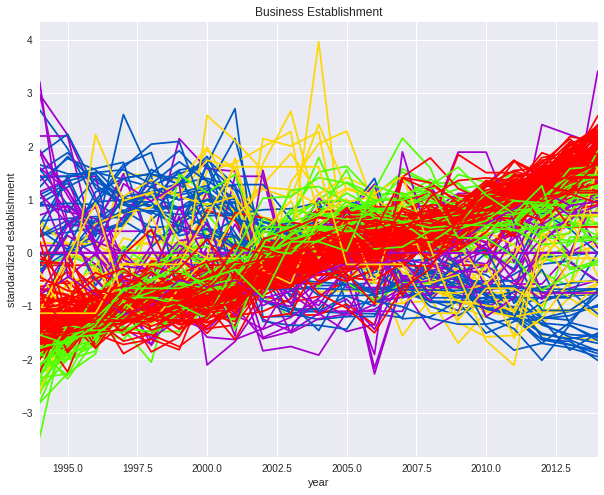

In [21]:
cmap = plt.cm.prism(np.linspace(0,1,5))
plt.figure(figsize=(10,8))
for i in range(len(df_pivot_std)):
    c = KMeanCluster.labels_[i]
    plt.plot(range(1994,2015), df_pivot_std.iloc[i,:], color=cmap[c][:3])
#for i in range(len(KMeanCluster.cluster_centers_)):
#    plt.plot(range(1994,2015), KMeanCluster.cluster_centers_[i], color="black", linewidth=3)
plt.title("Business Establishment")
plt.ylabel("standardized establishment")
plt.xlabel("year")
plt.xlim(1994,2014)

Fig.1 Plot all business together

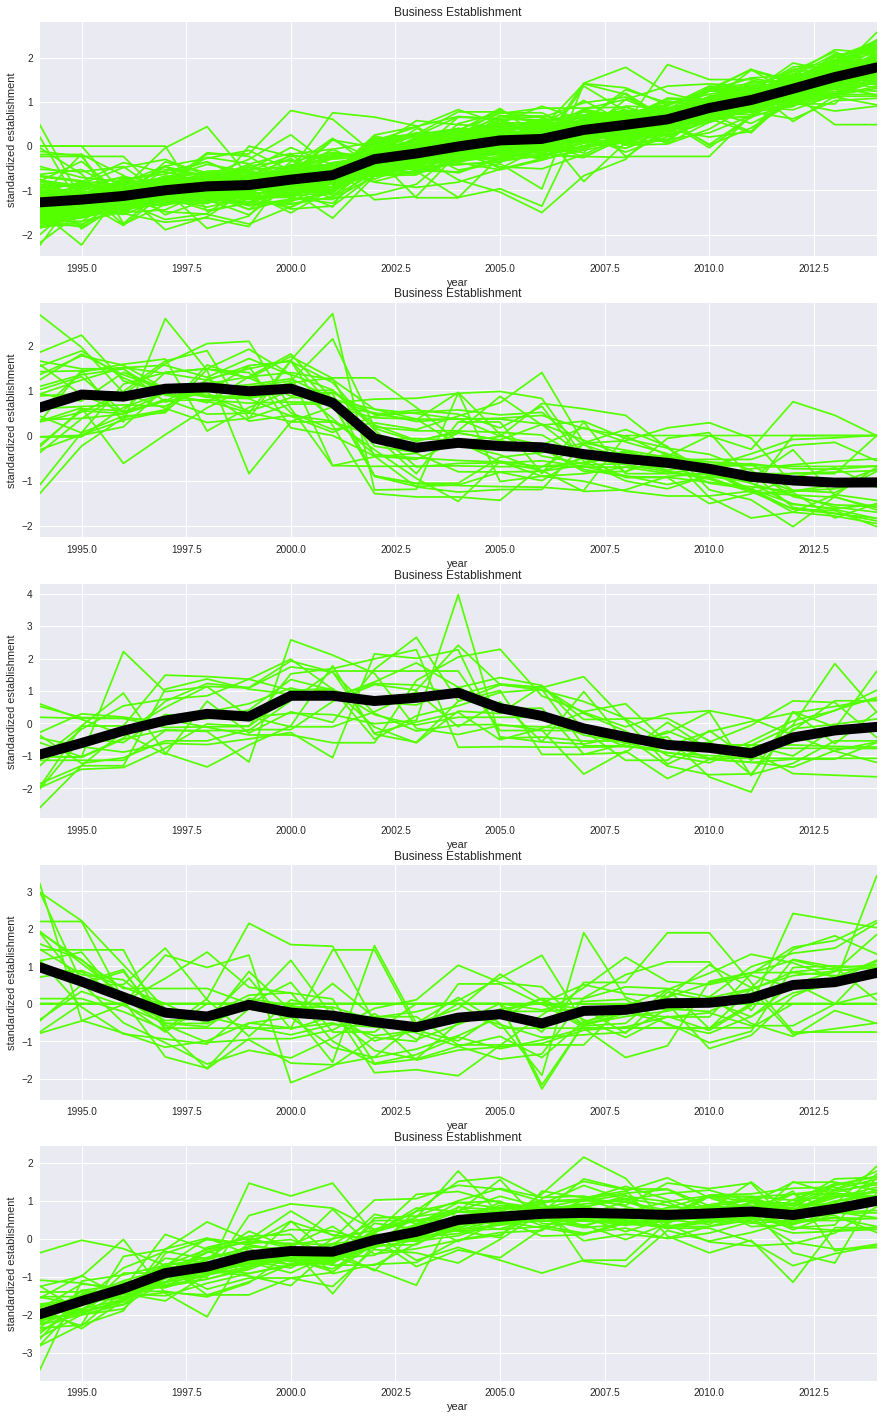

In [22]:
#plot the each cluster separately
plt.figure(figsize=(15, 25))

for M in range(0,5):
    plt.subplot(510+M+1)
    
    for i in range(len(df_pivot_std)):
        if(KMeanCluster.labels_[i]==M):
            plt.plot(range(1994,2015), df_pivot_std.iloc[i,:], color=cmap[c][:3])
        
    plt.plot(range(1994,2015), KMeanCluster.cluster_centers_[M], color="black", linewidth=10)
    plt.title("Business Establishment")
    plt.ylabel("standardized establishment")
    plt.xlabel("year")
    plt.xlim(1994,2014)


Fig.2 Plot each cluster in time series and its center line

In [23]:
Z = linkage(df_pivot_std.iloc[:,:].values, 'ward')

In [24]:
from scipy.cluster.hierarchy import set_link_color_palette
set_link_color_palette(['black'])

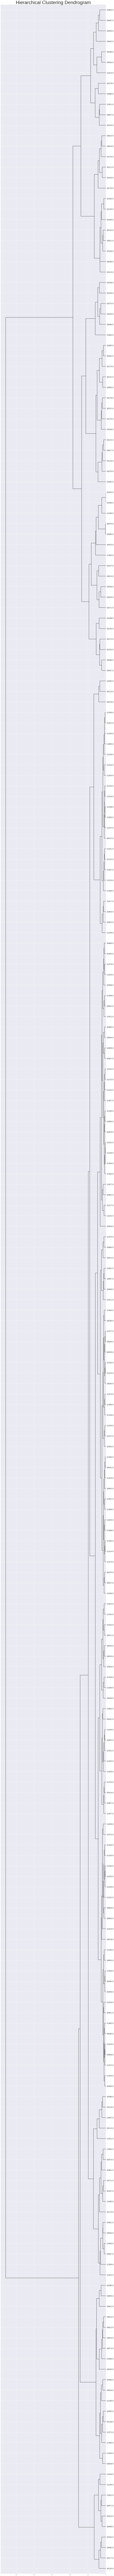

In [25]:
plt.figure(figsize=(20, 500))
plt.title('Hierarchical Clustering Dendrogram', fontsize=50)
dendrogram(
    Z,
    color_threshold=np.inf,
    orientation="left",
    labels = df_pivot_std.iloc[:,:].index.values,
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

Fig.3 Plot Hierarchy Cluster Result

In [26]:
AC = AgglomerativeClustering(n_clusters=5, linkage="ward").fit(df_pivot_std.iloc[:,:21])

In [27]:
KMdf = pd.DataFrame({"zip":df_pivot_std.index.values, "label":KMeanCluster.labels_})
ACdf = pd.DataFrame({"zip":df_pivot_std.index.values, "label":AC.labels_})

In [28]:
zipshp.rename(columns={"ZIPCODE":"zip"}, inplace=True)

In [29]:
zipshp["zip"] = pd.to_numeric(zipshp["zip"])

In [30]:
zipdf = zipshp.merge(KMdf, on="zip").merge(ACdf, on="zip")

In [31]:
zipdf.head()

,zip,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,label_x,label_y
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",0,1
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",0,1
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",0,1
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",0,1
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",0,1


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


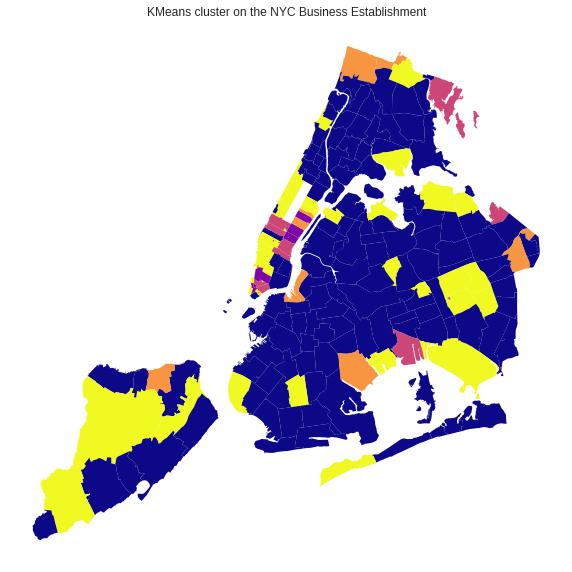

In [32]:
f, ax = plt.subplots(figsize=(10,10))
zipdf.plot(column="label_x", cmap="plasma", figsize=(15,10), ax=ax)
ax.set_title("KMeans cluster on the NYC Business Establishment")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_axis_bgcolor('white')

Fig.4 Plot the kmean result on NYC geomap

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


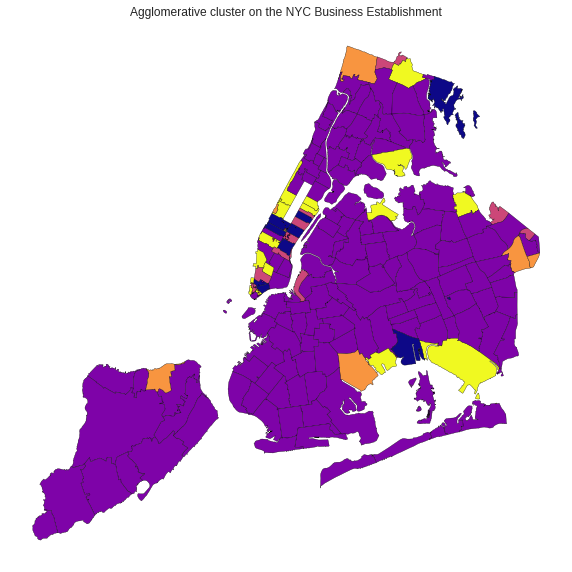

In [33]:
f, ax = plt.subplots(figsize=(10,10))
zipdf.plot(column="label_y", cmap="plasma", figsize=(15,10), ax=ax, edgecolor='k')
ax.set_title("Agglomerative cluster on the NYC Business Establishment")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_axis_bgcolor('white')

Fig.5 Plot the Hierarchy result on NYC geomap

Interpretation:
The result of the two clustering methods are very similar. The difference of the two plots may caused by the randomness of the two algorithmns. And kmeans results also depend on the number of clusters.
From the maps we can see most of the zipcode regions follow the same pattern over the years, however the small part of the zipcodes have different patterns. We can see the JFK and LGA airports are in the same group, east new york in Brooklyn and williamsburg are in the same group might because of their economy taking off. Interesting thing is in the kmeans method, the yellow cluster are the changing areas are the areas with many new immigrants/residents.

Points: 10